<a href="https://colab.research.google.com/github/Shivansh-datascience/Loan_Recovery_strategy/blob/main/Copy_of_Untitled75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Recovery Strategy Model

importing all packages required for strategy model

1. Data preprocessing Packages

In [1]:
import pandas as pd
from pyspark.sql.session import SparkSession
import numpy as np
import logging
import warnings
warnings.filterwarnings('ignore')

2.Visualization and distribution packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

3). Statistical Testing and Data Transformation library

In [3]:
from scipy import stats
from sklearn.preprocessing import LabelEncoder , OneHotEncoder , StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 , RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

4). Model buliding Pakages

In [4]:

from sklearn.cluster import KMeans , DBSCAN
from sklearn.tree import DecisionTreeClassifier , plot_tree

# Importing Data from Google colab environment

In [5]:
file_path = "/content/loan_data.csv"


spark = SparkSession.builder.appName('Session').getOrCreate()
print(spark)

In [6]:
#setting the info and warning alert for ETL processs
info = logging.basicConfig(level=logging.INFO)
warning = logging.basicConfig(level=logging.WARNING)
try:
  spark_csv = spark.read.csv(file_path , header = True , inferSchema = True)
  print(spark_csv)
  spark_csv.show()
except Exception as e:
  print(e)

#storing the spark frame into dataframe
try:
  loan_df = spark_csv.toPandas()
  print(loan_df)
except Exception as e:
  print(e)

DataFrame[_c0: int, Borrower_ID: string, Age: int, Gender: string, Employment_Type: string, Monthly_Income: int, Num_Dependents: int, Loan_ID: string, Loan_Amount: int, Loan_Tenure: int, Interest_Rate: double, Loan_Type: string, Collateral_Value: double, Outstanding_Loan_Amount: double, Monthly_EMI: double, Payment_History: string, Num_Missed_Payments: int, Days_Past_Due: int, Recovery_Status: string, Collection_Attempts: int, Collection_Method: string, Legal_Action_Taken: string]
+---+-----------+---+------+---------------+--------------+--------------+-------+-----------+-----------+-------------+---------+----------------+-----------------------+-----------+---------------+-------------------+-------------+-------------------+-------------------+-----------------+------------------+
|_c0|Borrower_ID|Age|Gender|Employment_Type|Monthly_Income|Num_Dependents|Loan_ID|Loan_Amount|Loan_Tenure|Interest_Rate|Loan_Type|Collateral_Value|Outstanding_Loan_Amount|Monthly_EMI|Payment_History|Num_

In [7]:
print(f" loan dataset has {loan_df.shape[0]} rows and {loan_df.shape[1]} columns")
print(f" loan dataset has {loan_df.columns.tolist()}")
print(f" loan dataset memory usage is {loan_df.memory_usage().sum()}")
print(f" loan dataset top 5 rows are {loan_df.head(5)}")
print(f" loan dataset last 5 rows are {loan_df.tail(5)}")

 loan dataset has 500 rows and 22 columns
 loan dataset has ['_c0', 'Borrower_ID', 'Age', 'Gender', 'Employment_Type', 'Monthly_Income', 'Num_Dependents', 'Loan_ID', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate', 'Loan_Type', 'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History', 'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status', 'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken']
 loan dataset memory usage is 70132
 loan dataset top 5 rows are    _c0 Borrower_ID  Age  Gender Employment_Type  Monthly_Income  \
0    0       BRW_1   59    Male        Salaried          215422   
1    1       BRW_2   49  Female        Salaried           60893   
2    2       BRW_3   35    Male        Salaried          116520   
3    3       BRW_4   63  Female        Salaried          140818   
4    4       BRW_5   28    Male        Salaried           76272   

   Num_Dependents Loan_ID  Loan_Amount  Loan_Tenure  ...  Collateral_Value  \
0               0    L

# Data Cleaning

1).Identifying the null values and duplicate values

In [8]:
#identify the null values in all columns
def identify_null_columns(loan_df):
  null_values = loan_df.isnull().sum()
  return null_values

null_values = identify_null_columns(loan_df)
percentage = (null_values.sum()/len(loan_df))*100
print(f" percentage of null values is {percentage} %")

 percentage of null values is 0.0 %


2). identifying the duplicate values that may be generated

In [9]:
#identify the columns which consist of duplicate values
def identify_duplicate_columns(loan_df):
  dupliacte_values = loan_df.duplicated().sum()
  return dupliacte_values

duplicate_values = identify_duplicate_columns(loan_df)
percentage_duplicate = (duplicate_values/len(loan_df))*100
print(f" percentage of duplicate values is {percentage_duplicate} %")

 percentage of duplicate values is 0.0 %


3). arranging the columns with appropiate datatype

In [10]:
#creating an list of all three datatype
int_columns = []
float_columns = []
categorical_columns = []

for columns in loan_df.columns:
  if loan_df[columns].dtype == 'int64':
    int_columns.append(columns)
  elif loan_df[columns].dtype == 'float64':
    float_columns.append(columns)
  else:
    categorical_columns.append(columns)

print(f" integer columns are {int_columns}")
print(f" float columns are {float_columns}")
print(f" categorical columns are {categorical_columns}")

 integer columns are []
 float columns are ['Interest_Rate', 'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI']
 categorical columns are ['_c0', 'Borrower_ID', 'Age', 'Gender', 'Employment_Type', 'Monthly_Income', 'Num_Dependents', 'Loan_ID', 'Loan_Amount', 'Loan_Tenure', 'Loan_Type', 'Payment_History', 'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status', 'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken']


from Above observation we Conclude that
1. Age column must be type of integer data type but assigned with categorical datatype
2. Monthly income must be type of integer data type
3. num of dependents should be of integer
4. Loan ID and Loan tenure , Num _missed payments

In [11]:
#changing the data type for columns for data consistancy
loan_df['Age'] = loan_df['Age'].astype('int64')
loan_df['Outstanding_loan_amount'] = loan_df['Outstanding_Loan_Amount'].astype('int64')
loan_df['Num_Dependents'] = loan_df['Num_Dependents'].astype('int64')
loan_df['Monthly_EMI'] = loan_df['Monthly_EMI'].astype('int64')
loan_df['Loan_Tenure'] - loan_df['Loan_Tenure'].astype('int64')
loan_df['Num_Missed_Payments'] = loan_df['Num_Missed_Payments'].astype('int64')
loan_df['Collateral_Value'] = loan_df['Collateral_Value'].astype('int64')
loan_df['Monthly_Income'] = loan_df['Monthly_Income'].astype('int64')

descriptive summary of columns

In [12]:
print(f" descriptive summary of columns are {loan_df.describe()}")

 descriptive summary of columns are               _c0         Age  Monthly_Income  Num_Dependents   Loan_Amount  \
count  500.000000  500.000000      500.000000      500.000000  5.000000e+02   
mean   249.500000   43.116000   134829.920000        1.476000  1.024907e+06   
std    144.481833   12.733217    68969.356746        1.145447  5.907556e+05   
min      0.000000   21.000000    15207.000000        0.000000  5.413800e+04   
25%    124.750000   32.000000    76343.250000        0.000000  4.629848e+05   
50%    249.500000   44.000000   134929.500000        1.000000  9.971240e+05   
75%    374.250000   53.000000   193086.250000        3.000000  1.557952e+06   
max    499.000000   64.000000   249746.000000        3.000000  1.995325e+06   

       Loan_Tenure  Interest_Rate  Collateral_Value  Outstanding_Loan_Amount  \
count    500.00000     500.000000      5.000000e+02             5.000000e+02   
mean      46.10400      11.192820      6.032237e+05             5.627260e+05   
std       18

How does monthly income correlate with the ability to repay loans?

In [ ]:
#calculating the monthly income relationhip of recovery status
monthly_income_relations_with_recovery = loan_df.groupby('Recovery_Status')['Monthly_Income'].mean().reset_index()
print(monthly_income_relations_with_recovery)

fig = px.histogram(
    monthly_income_relations_with_recovery,x="Recovery_Status",y="Monthly_Income",
    color="Recovery_Status",
)

fig.update_layout(
    title="Monthly Income Relationship with Recovery Status",
    xaxis_title="Recovery Status",
    yaxis_title="Monthly Income",
    showlegend=True,
    bargap=0.5,
)

fig.show()

       Recovery_Status  Monthly_Income
0      Fully Recovered   136311.469595
1  Partially Recovered   133904.980519
2          Written Off   128907.960000


identifying the relationship of repayment of laon on based on number of number of missed payments

In [ ]:
#calculating the number  repyaments loan on the basis of number of missed payemnts along with loan_amount and loan_tenure
num_repayments = loan_df.groupby(['Num_Missed_Payments','Recovery_Status'])['Outstanding_loan_amount'].mean().reset_index().sort_values(by="Recovery_Status")
print(num_repayments)


fig = px.bar(
    num_repayments,x="Num_Missed_Payments",y="Outstanding_loan_amount",
    color="Recovery_Status",barmode="group"
    )

fig.update_layout(
    title="Number of Missed payments for average loan amount along with recovery status"
)

    Num_Missed_Payments      Recovery_Status  Outstanding_loan_amount
0                     0      Fully Recovered             5.731192e+05
22                   11      Fully Recovered             2.469945e+05
3                     1      Fully Recovered             5.301553e+05
20                   10      Fully Recovered             1.083873e+06
6                     2      Fully Recovered             5.366263e+05
18                    9      Fully Recovered             3.260035e+05
9                     3      Fully Recovered             7.118854e+05
16                    8      Fully Recovered             9.153450e+04
12                    4      Fully Recovered             7.538330e+05
25                   12      Fully Recovered             5.532888e+05
14                    6      Fully Recovered             5.523653e+05
15                    7      Fully Recovered             4.702410e+05
23                   11  Partially Recovered             1.290896e+06
21                  

In [ ]:
#Do borrowers with higher loan amounts have a higher default rate


borrowers_with_higher_loan_amount_recovery_rate = loan_df.groupby(['Borrower_ID','Recovery_Status']).agg({"Outstanding_loan_amount":"max"}).reset_index().sort_values(by="Recovery_Status")
print(borrowers_with_higher_loan_amount_recovery_rate)

fig = px.funnel_area(
    borrowers_with_higher_loan_amount_recovery_rate,
    names="Recovery_Status",
    values="Outstanding_loan_amount",
    title="Borrowers with Higher Loan Amounts Have a Higher Default Rate"
)
fig.update_layout(
    title="Borrowers with Higher Loan Amounts Have a Higher Default Rate"
)


    Borrower_ID  Recovery_Status  Outstanding_loan_amount
249     BRW_323  Fully Recovered                    19785
289      BRW_36  Fully Recovered                   395791
288     BRW_359  Fully Recovered                   750748
287     BRW_358  Fully Recovered                   533824
286     BRW_357  Fully Recovered                  1635694
..          ...              ...                      ...
229     BRW_305      Written Off                   125797
100      BRW_19      Written Off                   176912
469      BRW_71      Written Off                  1138870
92      BRW_182      Written Off                    50698
240     BRW_315      Written Off                   248884

[500 rows x 3 columns]


Which collection method (legal action, settlement, debt collectors, calls) has the highest recovery success rate?

In [ ]:
success_rate = loan_df.groupby('Collection_Method').agg({'Recovery_Status':'count'}).reset_index()
print(success_rate)

fig = px.pie(
    success_rate,
    names='Collection_Method',
    values='Recovery_Status',
    title='Recovery Success Rate by Collection Method',
    hole=0.6,
    color_discrete_sequence=px.colors.sequential.RdBu
)

fig.update_layout(
    title="Recovery Success Rate by Collection Method"
)

  Collection_Method  Recovery_Status
0             Calls              129
1   Debt Collectors              125
2      Legal Notice              126
3  Settlement Offer              120


# How payment attacks the loan recovery status

In [ ]:
payemnts_attacks_recovery_status = loan_df.groupby(['Payment_History'])['Recovery_Status'].value_counts().unstack().fillna(0)
print(payemnts_attacks_recovery_status)


fig = px.bar(
    payemnts_attacks_recovery_status,
    x=payemnts_attacks_recovery_status.index,
    y=payemnts_attacks_recovery_status.columns,
    barmode='group',
    error_y=payemnts_attacks_recovery_status.columns,
    title="Payment Attacks on Loan Recovery Status"
)
fig.update_layout(
    title="Payment Attacks on Loan Recovery Status"
)


Recovery_Status  Fully Recovered  Partially Recovered  Written Off
Payment_History                                                   
Delayed                       79                   46           15
Missed                        35                   14            5
On-Time                      182                   94           30


In [ ]:
#how missed payment affect the loan repayment status
missed_payments_repayment_status = loan_df.groupby(['Num_Missed_Payments'])['Recovery_Status'].value_counts().unstack().fillna(0)
print(missed_payments_repayment_status)

fig = px.bar(
    missed_payments_repayment_status,
    x=missed_payments_repayment_status.index,
    y=missed_payments_repayment_status.columns,
    barmode='group'

)
fig.update_layout(
    title="Missed Payments on Loan Repayment Status"
)

Recovery_Status      Fully Recovered  Partially Recovered  Written Off
Num_Missed_Payments                                                   
0                               67.0                 42.0         10.0
1                               71.0                 35.0         17.0
2                               66.0                 37.0          8.0
3                               68.0                 33.0         14.0
4                                4.0                  1.0          0.0
6                                6.0                  0.0          0.0
7                                1.0                  0.0          0.0
8                                2.0                  2.0          0.0
9                                2.0                  1.0          0.0
10                               3.0                  1.0          0.0
11                               2.0                  1.0          1.0
12                               4.0                  1.0          0.0


averge of number of missed payments as 3 that loan can fully be recovered

In [ ]:
#how loans have been recovered based on legal action notices
loan_recovery_status = pd.crosstab(loan_df['Legal_Action_Taken'],loan_df['Recovery_Status']).reset_index()
print(loan_recovery_status)

fig  = make_subplots(rows=1,cols=3,subplot_titles=("Legal Action Taken","Recovery Status","Recovery Status"))
fig.add_trace(go.Bar(x=loan_recovery_status['Legal_Action_Taken'],y=loan_recovery_status['Fully Recovered'],name="Fully Recovered"),row=1,col=1)
fig.add_trace(go.Bar(x=loan_recovery_status['Legal_Action_Taken'],y=loan_recovery_status['Partially Recovered'],name="Default"),row=1,col=2)
fig.add_trace(go.Bar(x=loan_recovery_status['Legal_Action_Taken'],y=loan_recovery_status['Written Off'],name="Written Off"),row=1,col=3)

fig.update_layout(
    title="Loan Recovery Status Based on Legal Action Taken"
)

Recovery_Status Legal_Action_Taken  Fully Recovered  Partially Recovered  \
0                               No              296                  154   
1                              Yes                0                    0   

Recovery_Status  Written Off  
0                         26  
1                         24  


# Segementing the borrowers based on Loan financial information

performing the chi square testing to select the best features

In [13]:
from scipy.stats import chi2_contingency

for columns in loan_df.columns:
  chi2_stats, chi2_p_value, dof, expected = chi2_contingency(pd.crosstab(loan_df[columns],loan_df['Recovery_Status']))
  threshold_value = 0.05
  if chi2_p_value < threshold_value:
    print(f"{columns} : Reject the null hypothesis")
  else:
    print(f"{columns} : Accept the null hypothesis")

_c0 : Accept the null hypothesis
Borrower_ID : Accept the null hypothesis
Age : Accept the null hypothesis
Gender : Accept the null hypothesis
Employment_Type : Accept the null hypothesis
Monthly_Income : Accept the null hypothesis
Num_Dependents : Accept the null hypothesis
Loan_ID : Accept the null hypothesis
Loan_Amount : Accept the null hypothesis
Loan_Tenure : Accept the null hypothesis
Interest_Rate : Accept the null hypothesis
Loan_Type : Accept the null hypothesis
Collateral_Value : Accept the null hypothesis
Outstanding_Loan_Amount : Accept the null hypothesis
Monthly_EMI : Accept the null hypothesis
Payment_History : Accept the null hypothesis
Num_Missed_Payments : Accept the null hypothesis
Days_Past_Due : Accept the null hypothesis
Recovery_Status : Reject the null hypothesis
Collection_Attempts : Reject the null hypothesis
Collection_Method : Accept the null hypothesis
Legal_Action_Taken : Reject the null hypothesis
Outstanding_loan_amount : Accept the null hypothesis


selecting the best features according to domain

In [14]:
features = ['Age','Monthly_Income','Loan_Amount','Loan_Tenure','Interest_Rate','Collateral_Value','Outstanding_Loan_Amount','Monthly_EMI','Payment_History','Num_Missed_Payments',
    'Days_Past_Due']

features_df = loan_df[features]
print(features_df)

     Age  Monthly_Income  Loan_Amount  Loan_Tenure  Interest_Rate  \
0     59          215422      1445796           60          12.39   
1     49           60893      1044620           12          13.47   
2     35          116520      1923410           72           7.74   
3     63          140818      1811663           36          12.23   
4     28           76272        88578           48          16.13   
..   ...             ...          ...          ...            ...   
495   46          248483       740796           72          16.59   
496   30          243590      1408126           60          11.03   
497   46          113864       375203           48           9.16   
498   54          158401      1769890           24          11.19   
499   61           40169       394866           12           9.14   

     Collateral_Value  Outstanding_Loan_Amount  Monthly_EMI Payment_History  \
0             1727997             2.914130e+05         4856         On-Time   
1            

scaling the features into one dimension

In [15]:
#converting the columns into numerical representation
features_df['Payment_History'] = LabelEncoder().fit_transform(features_df['Payment_History'])

#now scalimg down the features into one dimensional arrya
def standarized_function(features_df):
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(features_df)
  return scaled_features

scaled_features = standarized_function(features_df)
print(scaled_features)


[[ 1.24869528  1.16969038  0.71317223 ...  0.75550144 -0.90696046
  -1.17501354]
 [ 0.46256126 -1.07309929  0.03340249 ...  0.75550144 -0.90696046
  -1.17501354]
 [-0.63802637 -0.26574494  1.52246178 ... -1.50647892  0.04174295
   0.88647205]
 ...
 [ 0.22672105 -0.30429336 -1.10088624 ... -1.50647892  0.51609466
   1.15247019]
 [ 0.85562827  0.34210391  1.26233094 ...  0.75550144  0.51609466
  -1.02538958]
 [ 1.40592208 -1.3738815  -1.06756842 ...  0.75550144 -0.43260876
   0.75347298]]


In [16]:
new_features_df = pd.DataFrame(scaled_features,columns=features_df.columns)
print(new_features_df)

          Age  Monthly_Income  Loan_Amount  Loan_Tenure  Interest_Rate  \
0    1.248695        1.169690     0.713172     0.762728       0.317434   
1    0.462561       -1.073099     0.033402    -1.871911       0.603797   
2   -0.638026       -0.265745     1.522462     1.421388      -0.915520   
3    1.563149        0.086909     1.333113    -0.554592       0.275010   
4   -1.188320       -0.849893    -1.586556     0.104068       1.309099   
..        ...             ...          ...          ...            ...   
495  0.226721        1.649528    -0.481410     1.421388       1.431069   
496 -1.031093        1.578513     0.649343     0.762728      -0.043172   
497  0.226721       -0.304293    -1.100886     0.104068      -0.539005   
498  0.855628        0.342104     1.262331    -1.213251      -0.000748   
499  1.405922       -1.373881    -1.067568    -1.871911      -0.544308   

     Collateral_Value  Outstanding_Loan_Amount  Monthly_EMI  Payment_History  \
0            1.509830          

Text(0.5, 1.0, 'Scaled Age vs Scaled Monthly Income')

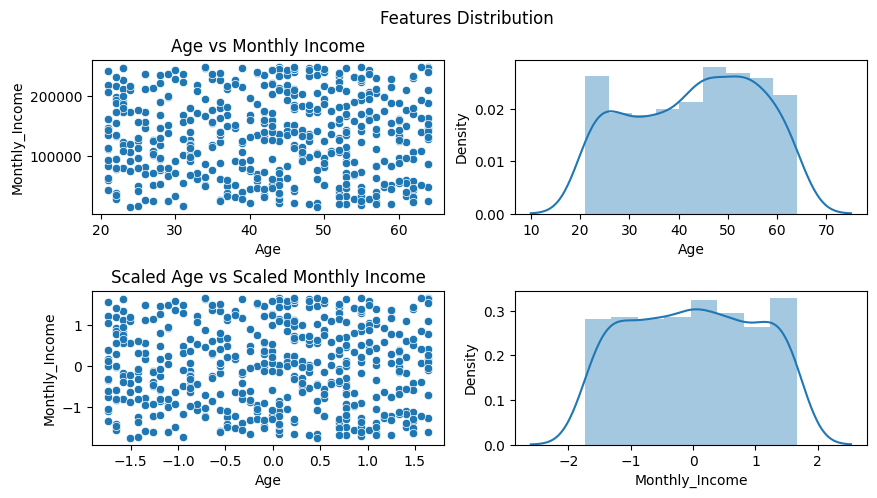

In [ ]:
fig , ax = plt.subplots(nrows=2,ncols=2,figsize=(10,5))
fig.suptitle("Features Distribution")
fig.subplots_adjust(hspace=0.5)



sns.scatterplot(features_df,x="Age",y="Monthly_Income",ax=ax[0,0])
sns.distplot(features_df['Age'],ax=ax[0,1])
sns.scatterplot(new_features_df,x="Age",y="Monthly_Income",ax=ax[1,0])
sns.distplot(new_features_df['Monthly_Income'],ax=ax[1,1])
ax[0,0].set_title("Age vs Monthly Income")
ax[1,0].set_title("Scaled Age vs Scaled Monthly Income")

splitting the features into train test purpose

In [17]:
class train_test_splitter:

  def __init__(self,new_features_df):
    self.new_features_df = new_features_df
    self.train_size = 0.7
    self.test_size = 0.3
    self.random_state = np.random.randint(low=1,high=100)

  def split_features(self):
    X_train , X_test = train_test_split(self.new_features_df,train_size=self.train_size,test_size=self.test_size,random_state=self.random_state)
    return X_train , X_test

splitter = train_test_splitter(new_features_df)
X_train , X_test = splitter.split_features()
print(X_train)
print(X_test)

          Age  Monthly_Income  Loan_Amount  Loan_Tenure  Interest_Rate  \
428 -0.873867       -0.451332    -0.846335     0.104068       0.399631   
41  -0.402186       -1.513300     0.666641     0.104068       0.221979   
218 -0.087733        0.563714    -1.009273     0.762728       1.608720   
147  1.563149        0.411160    -1.241550     0.762728       1.505311   
12   1.012855        1.584855     1.619621     0.762728      -0.666277   
..        ...             ...          ...          ...            ...   
356  1.563149       -0.374627     1.338127    -0.554592      -1.058701   
448  1.091468       -1.467016     1.319734    -1.871911      -0.767035   
300 -0.087733        1.451822     1.008747     0.104068      -1.079913   
132 -1.109707       -0.954551    -0.841797     1.421388       1.767811   
373 -0.009119       -1.289150    -1.048691    -0.554592      -1.299989   

     Collateral_Value  Outstanding_Loan_Amount  Monthly_EMI  Payment_History  \
428         -0.376035          

# selecting the optimal components for segements using wccs method

Text(0, 0.5, 'WCSS')

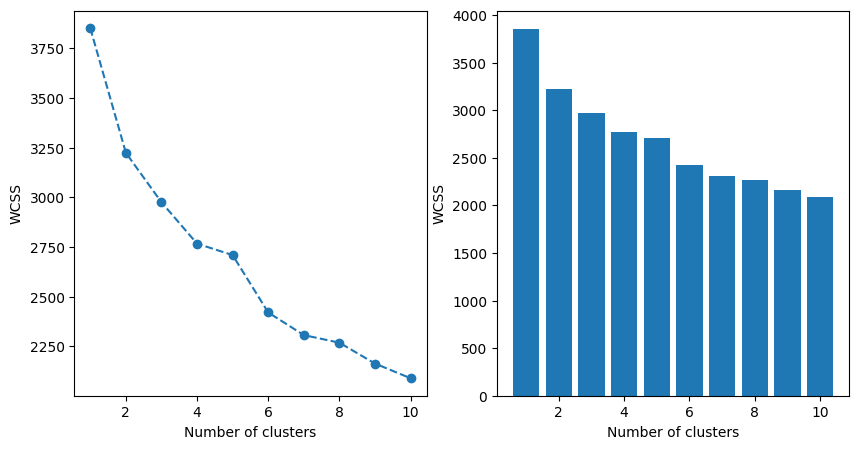

In [18]:

#creating an wccs instance of empty list
wccs = []

#assigning the starting iteration to last iteration of clusters
start_iter = 1
end_iter = 11

for i in range(start_iter,end_iter):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
  kmeans.fit(X_train)
  wccs.append(kmeans.inertia_)

#plotting the line plot to elbow distribution
fig , ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.subplots_adjust(hspace=0.5)

#adding the elbow method
ax[0].plot(range(start_iter,end_iter),wccs,marker='o',linestyle='--')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('WCSS')

#adding the distribution
ax[1].bar(range(start_iter,end_iter),wccs)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('WCSS')

In [20]:
wccs

[3851.978480417197,
 3224.100785381123,
 2974.887886678252,
 2766.445360681632,
 2708.715582849381,
 2419.538078645277,
 2305.6579312811436,
 2267.3342420433087,
 2162.2183406161153,
 2088.228093081258]

selecting the optimal number of clusters as four because borrowers can be segemented into four clusters

1.   Low risk
2.   High risk
3.   moderate Risk
4.   deafulters



# creating an clustering model using Kmeans

In [21]:
#initializing the clusters with wccs method
class ClusteringGroup:
  def __init__(self,X_train,X_test):
    self.clusters = wccs.index(2708.715582849381)  #selecting the index value i.e clusters
    self.init = "k-means++"
    self.random_state = np.random.randint(low=1,high=100)
    self.X_train = X_train
    self.X_test = X_test

  def clustering_model(self):
    kmeans = KMeans(n_clusters=self.clusters,init=self.init,random_state=self.random_state)
    return kmeans

  def get_segments_labels(self,kmeans):
    kmeans.fit(self.X_train)
    segments_group = kmeans.predict(self.X_test)
    return segments_group

cluster_group = ClusteringGroup(X_train,X_test)
kmeans = cluster_group.clustering_model()
segments_group = cluster_group.get_segments_labels(kmeans)
print(f" Risk segemented groups : {segments_group}")

 Risk segemented groups : [0 1 3 1 2 0 3 3 1 2 1 3 1 2 2 3 0 0 1 3 1 0 1 1 2 2 3 2 2 3 2 3 3 1 3 2 3
 3 3 3 1 1 3 3 1 0 3 1 1 0 3 2 3 1 1 1 0 3 3 2 2 1 3 0 2 1 1 0 3 1 3 3 0 2
 1 0 1 2 0 3 2 0 3 0 3 3 1 1 0 2 0 0 1 2 1 3 2 1 0 0 0 3 1 0 0 0 3 1 0 3 1
 0 2 1 2 3 1 0 1 3 0 1 1 3 0 3 1 1 3 3 2 2 1 2 0 0 3 0 0 3 2 0 2 2 1 3 0 0
 1 3]


1. 0 group = Low Risk Borrowers
2. 1 group = Moderate Risk Borrowers
3. 2 group = High Risk Borrowers
3. 3 group = Defaulters

In [22]:
loan_df['Segments'] = kmeans.fit_predict(new_features_df)
print(loan_df)

     _c0 Borrower_ID  Age  Gender Employment_Type  Monthly_Income  \
0      0       BRW_1   59    Male        Salaried          215422   
1      1       BRW_2   49  Female        Salaried           60893   
2      2       BRW_3   35    Male        Salaried          116520   
3      3       BRW_4   63  Female        Salaried          140818   
4      4       BRW_5   28    Male        Salaried           76272   
..   ...         ...  ...     ...             ...             ...   
495  495     BRW_496   46  Female        Salaried          248483   
496  496     BRW_497   30  Female        Salaried          243590   
497  497     BRW_498   46  Female        Salaried          113864   
498  498     BRW_499   54    Male        Salaried          158401   
499  499     BRW_500   61    Male   Self-Employed           40169   

     Num_Dependents Loan_ID  Loan_Amount  Loan_Tenure  ...  Monthly_EMI  \
0                 0    LN_1      1445796           60  ...         4856   
1                 0  

In [23]:
#assigned the clusters into labels
loan_df['borrower_segments'] = loan_df['Segments'].map({0:'Low Risk',1:'Moderate Risk',2:'High Risk',3:'Defaulters'})
print(loan_df)

     _c0 Borrower_ID  Age  Gender Employment_Type  Monthly_Income  \
0      0       BRW_1   59    Male        Salaried          215422   
1      1       BRW_2   49  Female        Salaried           60893   
2      2       BRW_3   35    Male        Salaried          116520   
3      3       BRW_4   63  Female        Salaried          140818   
4      4       BRW_5   28    Male        Salaried           76272   
..   ...         ...  ...     ...             ...             ...   
495  495     BRW_496   46  Female        Salaried          248483   
496  496     BRW_497   30  Female        Salaried          243590   
497  497     BRW_498   46  Female        Salaried          113864   
498  498     BRW_499   54    Male        Salaried          158401   
499  499     BRW_500   61    Male   Self-Employed           40169   

     Num_Dependents Loan_ID  Loan_Amount  Loan_Tenure  ...  Payment_History  \
0                 0    LN_1      1445796           60  ...          On-Time   
1            

In [24]:
#droping the segment columns
loan_df.drop(columns=['Segments'],inplace=True)

In [ ]:
loan_df.columns

Index(['_c0', 'Borrower_ID', 'Age', 'Gender', 'Employment_Type',
       'Monthly_Income', 'Num_Dependents', 'Loan_ID', 'Loan_Amount',
       'Loan_Tenure', 'Interest_Rate', 'Loan_Type', 'Collateral_Value',
       'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History',
       'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status',
       'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken',
       'Outstanding_loan_amount', 'borrower_segments'],
      dtype='object')

In [25]:
import pickle
import joblib

joblib.dump(kmeans,'loan_recovery_model.pkl')

['loan_recovery_model.pkl']

# How  segmentation affect loan recovery on the basis Monthly income and loan amount

In [ ]:
#plotting the scatter plot for borrower segmenation
fig = px.scatter(
    loan_df,x=loan_df['Monthly_Income'],
    y=loan_df['Loan_Amount'],
    color=loan_df['borrower_segments'],
    color_discrete_sequence=px.colors.qualitative.Vivid)

fig.add_annotation(
    x=loan_df['Monthly_Income'].max(),y=loan_df['Loan_Amount'].max(),
    showarrow=True,
    arrowcolor="green",
    text="High Monthly leads to High Borrowers"
)

fig.add_annotation(
    x=loan_df['Monthly_Income'].min(),y=loan_df['Loan_Amount'].min(),
    showarrow=True,
    arrowcolor="red",
    text="Low Monthly leads to Low Borrowers"
)

fig.add_annotation(
    x=loan_df['Monthly_Income'].mean(),y=loan_df['Loan_Amount'].mean(),
    showarrow=True,
    arrowcolor="black",
    text="minimum monthly income leads to moderate borrower"
)

fig.update_layout(
    title="Borrower Segmentation on the basis of Monthly Income and Loan Amount",
)

# How num of missed payments leads to risk borrower

In [ ]:
#num of payments leads to types of risk borrowers
fig = px.scatter(
    loan_df,x=loan_df['Num_Missed_Payments'],
    y=loan_df['borrower_segments'],
    color=loan_df['borrower_segments'],
    color_discrete_sequence=px.colors.qualitative.Vivid
)

#adding the text with low boorowers , high borrowers , deafulters and moderate borrowers
fig.add_annotation(
    x=loan_df['Num_Missed_Payments'].min(),y="Low Risk",
    showarrow=True,
    arrowcolor="green",
    text="min number of payments leads to Low Risk Borrowers"
)

fig.add_annotation(
    x=loan_df['Num_Missed_Payments'].max(),y="High Risk",
    showarrow=True,
    arrowcolor="red",
    text="max number of payments leads to High Risk Borrowers"
)

fig.add_annotation(
    x=loan_df['Num_Missed_Payments'].mean(),y="Moderate Risk",
    showarrow=True,
    arrowcolor="black",
    text="average number of payments leads to Moderate Risk Borrowers"
)

fig.update_layout(
    title="num of missed payments borrower segmentation")

plotting the decision tree model to see the risk decision

In [69]:
#selecting the features for making decision tree plot
loan_df_copy = loan_df.copy()

#selecting the features
X=loan_df.drop('borrower_segments',axis=1)
y=loan_df['borrower_segments']

In [70]:
print(f" Input features columns : {X.columns}")
print(f" Output Features columns : {y}")

 Input features columns : Index(['_c0', 'Borrower_ID', 'Age', 'Gender', 'Employment_Type',
       'Monthly_Income', 'Num_Dependents', 'Loan_ID', 'Loan_Amount',
       'Loan_Tenure', 'Interest_Rate', 'Loan_Type', 'Collateral_Value',
       'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History',
       'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status',
       'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken',
       'Outstanding_loan_amount'],
      dtype='object')
 Output Features columns : 0          High Risk
1      Moderate Risk
2      Moderate Risk
3          High Risk
4           Low Risk
           ...      
495       Defaulters
496       Defaulters
497       Defaulters
498    Moderate Risk
499         Low Risk
Name: borrower_segments, Length: 500, dtype: object


since we have selected only best features for risk segements so we will consider this only segements
'Age','Monthly_Income','Loan_Amount','Loan_Tenure','Interest_Rate','Collateral_Value','Outstanding_Loan_Amount','Monthly_EMI','Payment_History','Num_Missed_Payments','Days_Past_Due'

In [71]:
new_features = [
    'Age','Monthly_Income','Loan_Amount','Loan_Tenure','Interest_Rate','Collateral_Value','Outstanding_Loan_Amount','Monthly_EMI','Payment_History','Num_Missed_Payments','Days_Past_Due']

new_X = X[new_features]
print(new_X)

     Age  Monthly_Income  Loan_Amount  Loan_Tenure  Interest_Rate  \
0     59          215422      1445796           60          12.39   
1     49           60893      1044620           12          13.47   
2     35          116520      1923410           72           7.74   
3     63          140818      1811663           36          12.23   
4     28           76272        88578           48          16.13   
..   ...             ...          ...          ...            ...   
495   46          248483       740796           72          16.59   
496   30          243590      1408126           60          11.03   
497   46          113864       375203           48           9.16   
498   54          158401      1769890           24          11.19   
499   61           40169       394866           12           9.14   

     Collateral_Value  Outstanding_Loan_Amount  Monthly_EMI Payment_History  \
0             1727997             2.914130e+05         4856         On-Time   
1            

In [72]:
#encoding the values of input features
new_X['Payment_History'] = LabelEncoder().fit_transform(new_X['Payment_History'])

In [74]:
#plot the tree model with decision Tree model
dt_model = DecisionTreeClassifier(max_depth=4,criterion='entropy',min_samples_split=2)
dt_model.fit(new_X,y)

model_predict = dt_model.predict(new_X)
print(model_predict)

['High Risk' 'Moderate Risk' 'High Risk' 'High Risk' 'Low Risk' 'Low Risk'
 'High Risk' 'Defaulters' 'Low Risk' 'Defaulters' 'Low Risk' 'High Risk'
 'Moderate Risk' 'Low Risk' 'Defaulters' 'Moderate Risk' 'Moderate Risk'
 'Defaulters' 'High Risk' 'High Risk' 'Defaulters' 'Defaulters'
 'Defaulters' 'Defaulters' 'Defaulters' 'Moderate Risk' 'Moderate Risk'
 'Moderate Risk' 'Moderate Risk' 'Moderate Risk' 'Low Risk' 'Low Risk'
 'Low Risk' 'Low Risk' 'High Risk' 'High Risk' 'Defaulters' 'Low Risk'
 'High Risk' 'Defaulters' 'High Risk' 'High Risk' 'High Risk' 'High Risk'
 'Defaulters' 'High Risk' 'Defaulters' 'Low Risk' 'High Risk'
 'Moderate Risk' 'Low Risk' 'High Risk' 'High Risk' 'Low Risk'
 'Defaulters' 'Moderate Risk' 'Moderate Risk' 'Defaulters' 'High Risk'
 'High Risk' 'High Risk' 'Defaulters' 'Low Risk' 'Defaulters' 'Low Risk'
 'Defaulters' 'Low Risk' 'Defaulters' 'Low Risk' 'Moderate Risk'
 'High Risk' 'Low Risk' 'Defaulters' 'High Risk' 'Moderate Risk'
 'Low Risk' 'Low Risk' 'Mode

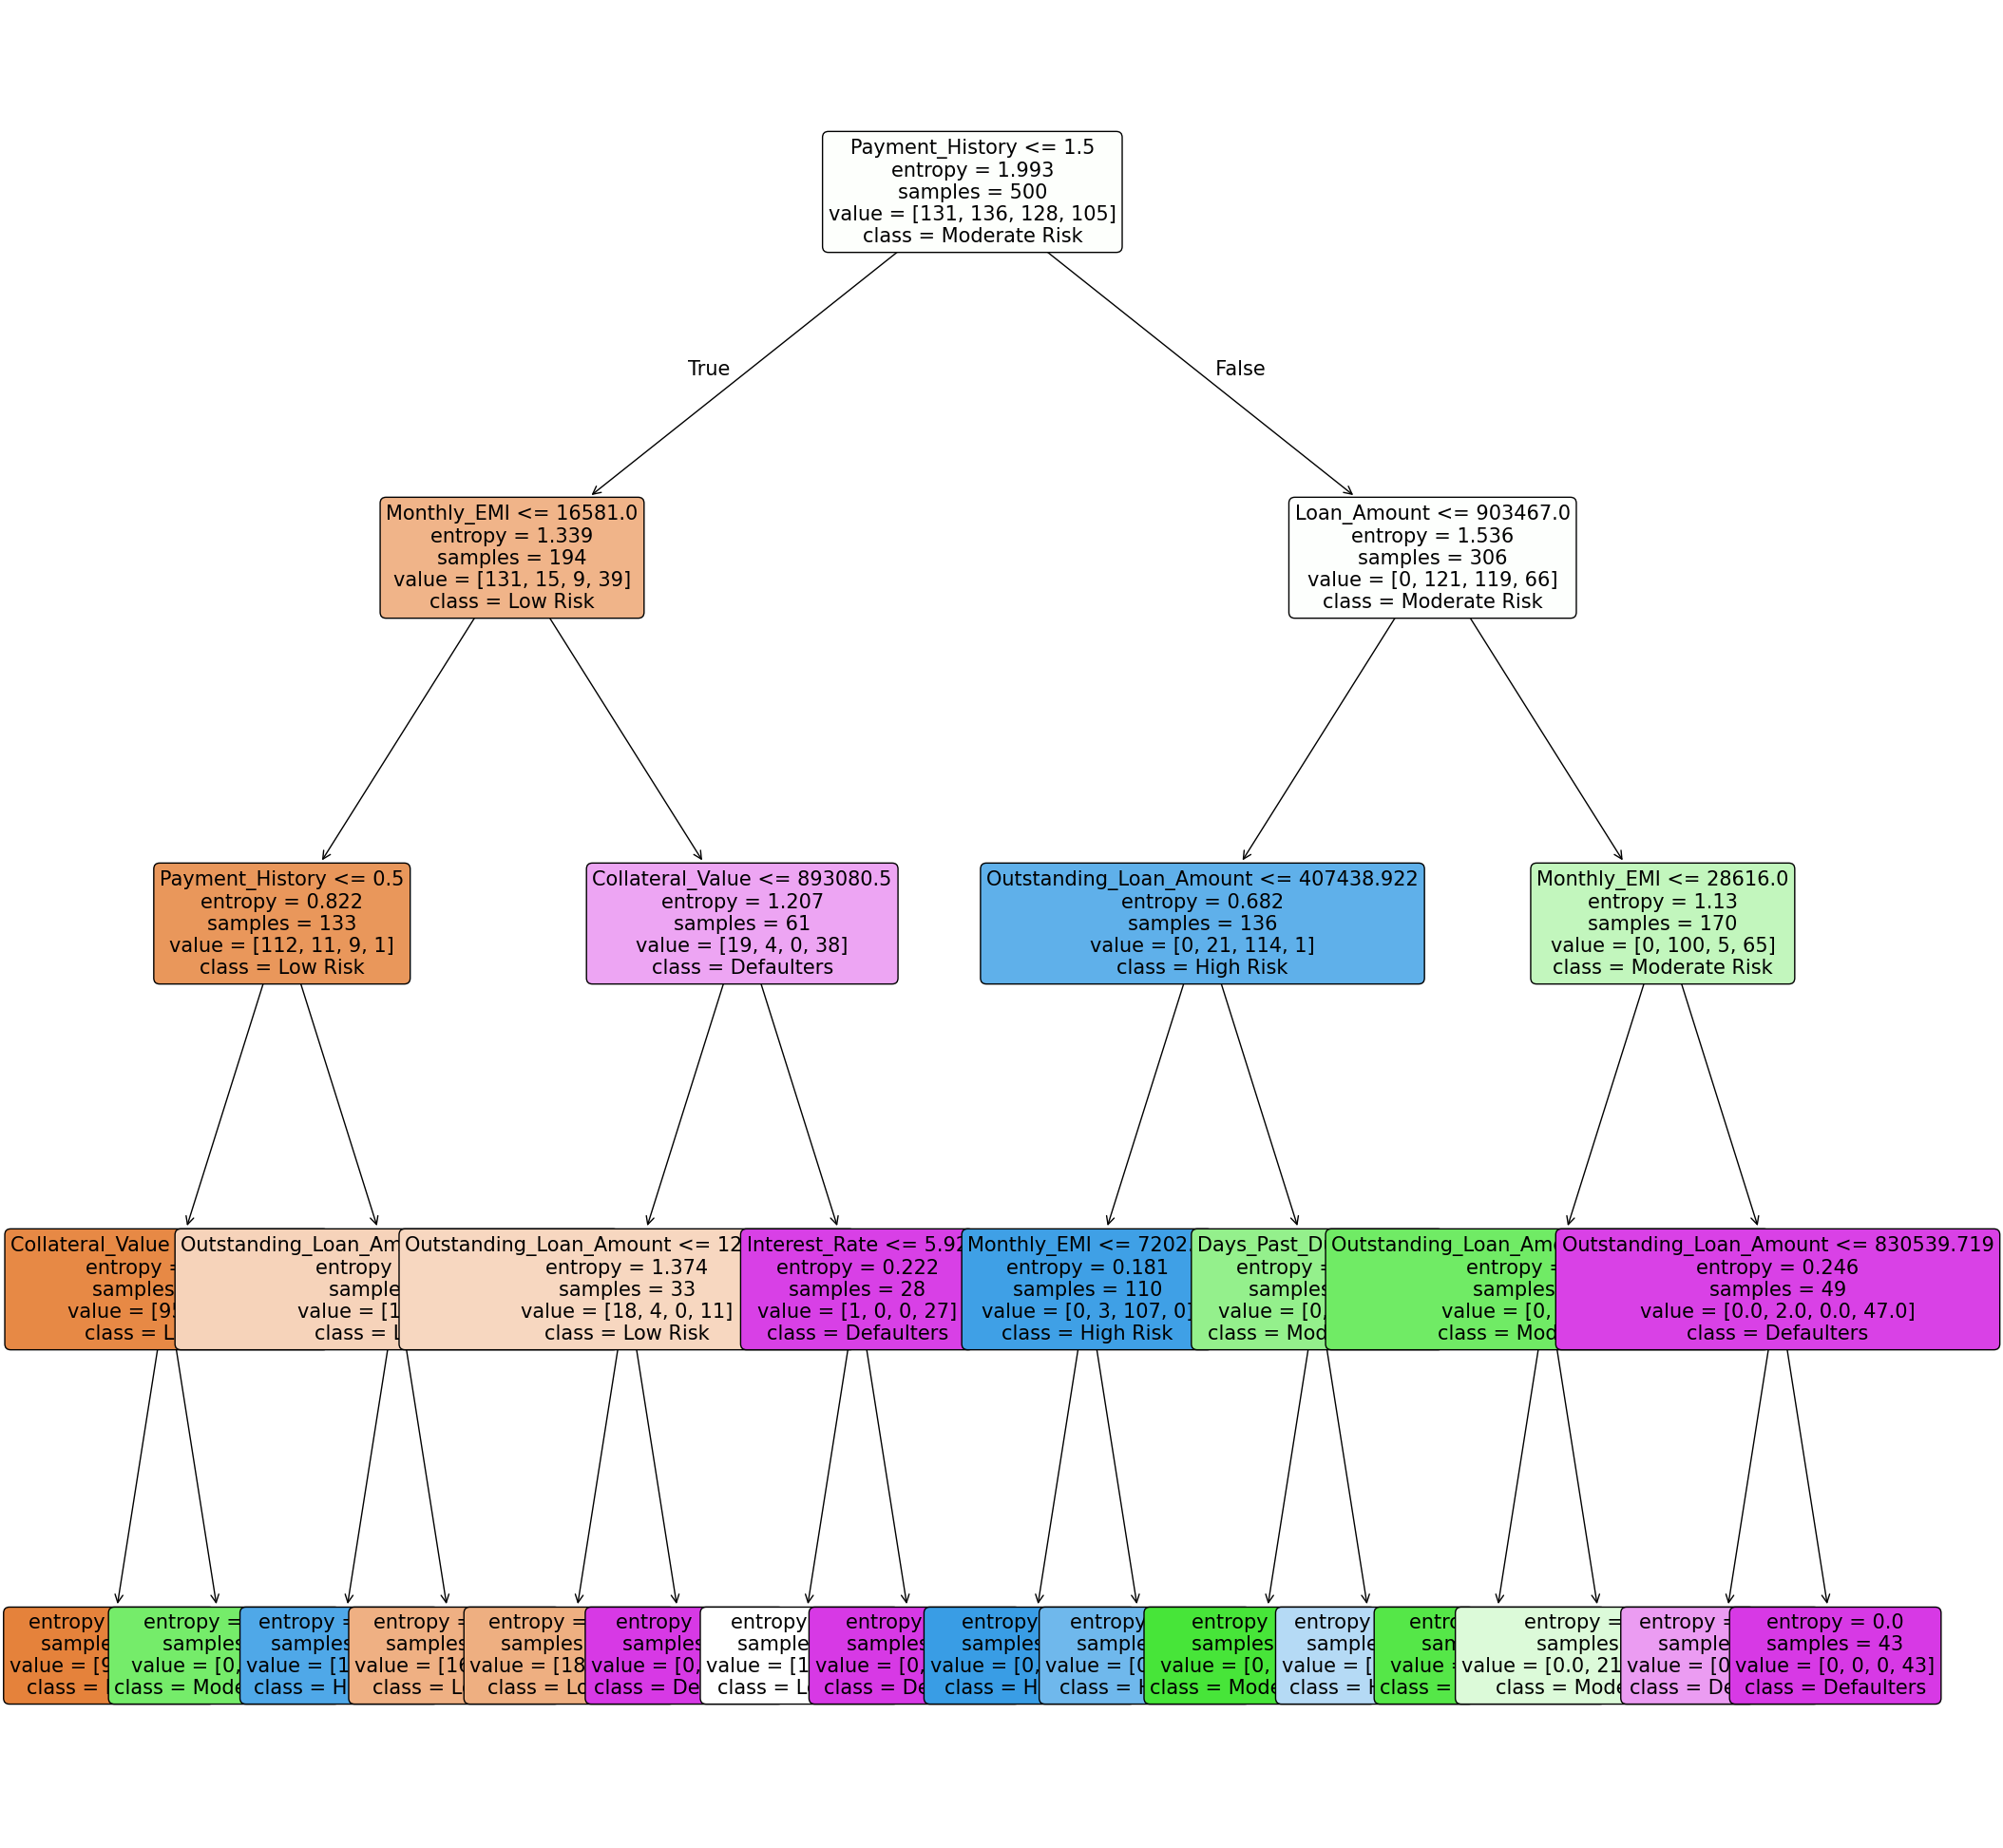

In [75]:
#plotting the decision tree model
fig = plt.figure(figsize=(25,25))
plot_tree(dt_model,filled=True,feature_names=new_features,class_names=['Low Risk','Moderate Risk','High Risk','Defaulters'],rounded=True,fontsize=15)
plt.savefig('tree.png')

[0.         0.         0.22475295 0.         0.00512302 0.05721007
 0.14418297 0.19882798 0.3551873  0.         0.01471571]


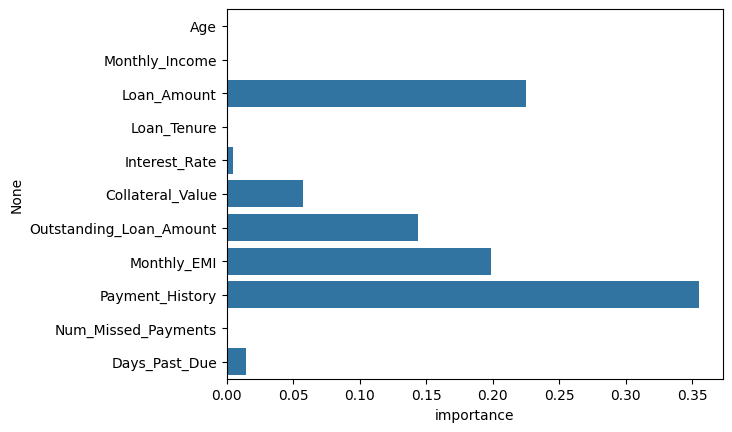

In [76]:
features_importances = dt_model.feature_importances_
print(features_importances)

df = pd.DataFrame(features_importances,index=new_features,columns=['importance'])


sns.barplot(df,x='importance',y=df.index)
plt.savefig('features_importances.png')